In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import  classification_report

In [2]:
from keras.applications.inception_v3 import InceptionV3

In [6]:
!pip install -q kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.
! kaggle datasets download -d emmarex/plantdisease
! unzip /content/plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

In [7]:
file_path = '/content/PlantVillage'

In [8]:
name_class = os.listdir(file_path)
name_class

['Tomato_Bacterial_spot',
 'Potato___Early_blight',
 'Pepper__bell___healthy',
 'Tomato_Leaf_Mold',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Late_blight',
 'Potato___healthy',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Potato___Late_blight']

In [9]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [10]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)


,Filepath,Label
0,/content/PlantVillage/Pepper__bell___Bacterial...,Pepper__bell___Bacterial_spot
1,/content/PlantVillage/Tomato_Septoria_leaf_spo...,Tomato_Septoria_leaf_spot
2,/content/PlantVillage/Tomato_healthy/ee83a3b8-...,Tomato_healthy
3,/content/PlantVillage/Tomato_Spider_mites_Two_...,Tomato_Spider_mites_Two_spotted_spider_mite
4,/content/PlantVillage/Tomato_Bacterial_spot/6b...,Tomato_Bacterial_spot


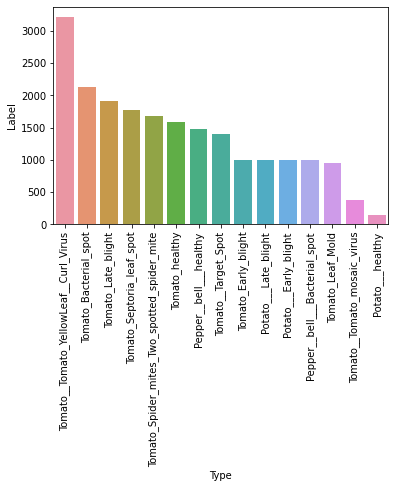

In [11]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [12]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

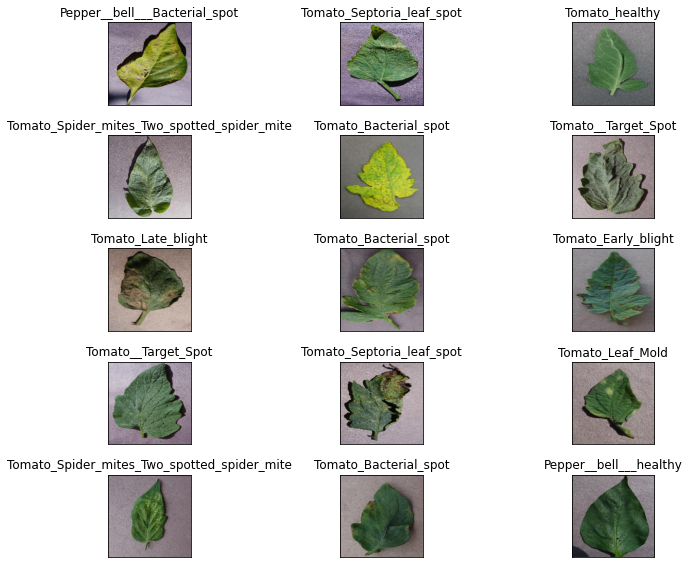

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [14]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 15478 validated image filenames belonging to 15 classes.
Found 15478 validated image filenames belonging to 15 classes.
Found 5160 validated image filenames belonging to 15 classes.


In [16]:
pretrained_model = InceptionV3(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [17]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(15, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [20]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

Epoch 1/10
484/484 [==============================] - 81s 123ms/step - loss: 1.2977 - accuracy: 0.5858 - val_loss: 0.8574 - val_accuracy: 0.7169
Epoch 2/10
484/484 [==============================] - 58s 120ms/step - loss: 0.8744 - accuracy: 0.7094 - val_loss: 0.7168 - val_accuracy: 0.7631
Epoch 3/10
484/484 [==============================] - 58s 119ms/step - loss: 0.7274 - accuracy: 0.7548 - val_loss: 0.5941 - val_accuracy: 0.8038
Epoch 4/10
484/484 [==============================] - 58s 120ms/step - loss: 0.6049 - accuracy: 0.7956 - val_loss: 0.4593 - val_accuracy: 0.8472
Epoch 5/10
484/484 [==============================] - 58s 120ms/step - loss: 0.5121 - accuracy: 0.8255 - val_loss: 0.3917 - val_accuracy: 0.8723
Epoch 6/10
484/484 [==============================] - 57s 119ms/step - loss: 0.4235 - accuracy: 0.8550 - val_loss: 0.3478 - val_accuracy: 0.8798
Epoch 7/10
484/484 [==============================] - 57s 117ms/step - loss: 0.3579 - accuracy: 0.8754 - val_loss: 0.2623 - val_ac

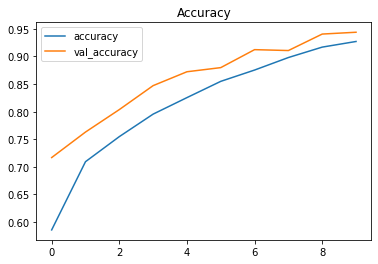

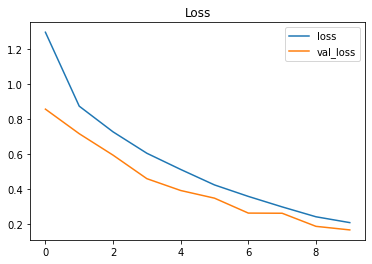

In [21]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [22]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.30166
Test Accuracy: 70.19%


In [23]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [24]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.70      0.64      0.67       261
                     Pepper__bell___healthy       0.74      0.89      0.81       370
                      Potato___Early_blight       0.83      0.85      0.84       246
                       Potato___Late_blight       0.69      0.63      0.66       247
                           Potato___healthy       0.50      0.50      0.50        38
                      Tomato_Bacterial_spot       0.65      0.86      0.74       551
                        Tomato_Early_blight       0.38      0.38      0.38       248
                         Tomato_Late_blight       0.68      0.66      0.67       459
                           Tomato_Leaf_Mold       0.55      0.72      0.62       234
                  Tomato_Septoria_leaf_spot       0.61      0.54      0.57       456
Tomato_Spider_mites_Two_spotted_spider_mite       0.71      0.64

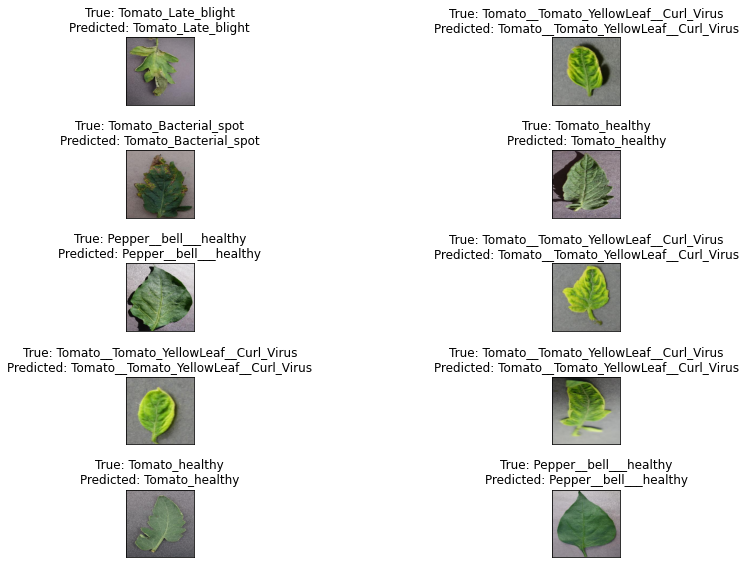

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()